# Gaussian process regression with varying output noise

This notebook will show how to construct a Gaussian process model where different noise is assumed for different datapoints. This model is

$$f(\cdot) \sim \mathcal{GP}\big(0, k(\cdot, \cdot)\big)$$
$$y_i | f, x_i \sim \mathcal N\big(y_i; f(x_i), \sigma^2_i\big)$$

To show how GPflow can be used for this type of problem, we'll demonstrate two methods. In the first, we'll assume that the noise variance is known for every data point. We'll incorporate the known noise variances $\sigma^2_i$ into the data matrix $\mathbf Y$, make a likelihood that can deal with this structure, and implement inference using Variational GPs with natural gradients. 

In the second demonstration, we'll assume that the noise variance is not known, but we'd like to estimate it for different groups of data. We'll show how to construct an appropriate likelihood for this task and set up inference similarly to the first, with optimization over the noise variances. 


In [21]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib
plt = matplotlib.pyplot
%matplotlib inline

# Demo 1: known noise variances
### Generate synthetic data
We create a utility function to generate synthetic data, including noise that varies amongst the data:

In [22]:
def generate_data(N=80):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x 1
    F = 2.5 * np.sin(6 * X) + np.cos(3 * X)  # Mean function values
    Sigma = np.exp(-(X - 2)**2 / 4) + 0.3  # Noise variances
    Y = F + np.random.randn(N, 1) * np.sqrt(Sigma)  # noisy data
    return X, Y, Sigma**2

X, Y, Sigma = generate_data()

Here's a plot of the data, with errorbars representing two standard deviations. 

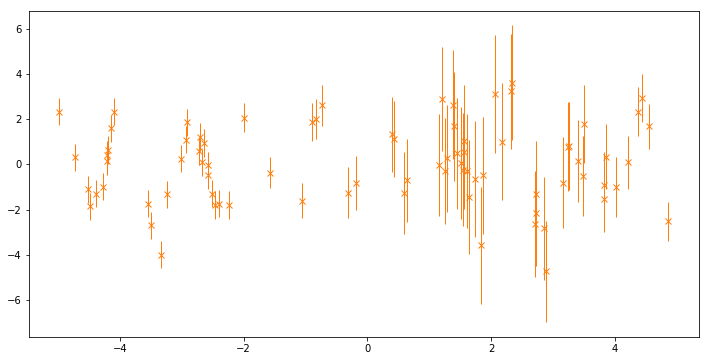

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
_ = ax.errorbar(X, Y, yerr=2*(np.sqrt(Sigma)), marker='x', lw=0, elinewidth=1., color='C1')

### Make a Y matrix that includes the variances
We ned to tell the GP model what the variance is for each datapoint. To do this, we'll concatenate the observations with the variances into a single data-matrix:

In [24]:
Y_data = np.hstack([Y, Sigma])

### Make a new likelihood

To cope with this data structure, we'll build a new likelihood. Note how the code extracts the observations Y and the variances Sigma from the data. For more information on creating new likelihoods, see [this notebook](../tailor/likelihood_design.ipynb). Here, we're implementing the logp function (which computes the log-probability of the data given the latent function) and 'variational expectations', which computes the expected log_p under a Gaussian distribution on the function. Check out the Likelihood object's docstring for more information on what these functions do. 

In [25]:
class HetGaussian(gpflow.likelihoods.Likelihood):
    def logp(self, F, Y):
        Y, Sigma = Y[:, 0:1], Y[:, 1:2]
        return gpflow.logdensities.gaussian(Y, F, Sigma)

    def conditional_mean(self, F):
        raise NotImplementedError

    def conditional_variance(self, F):
        raise NotImplementedError

    def variational_expectations(self, Fmu, Fvar, Y):
        Y, Sigma = Y[:, 0:1], Y[:, 1:2]
        return -0.5 * np.log(2 * np.pi) - 0.5 * tf.log(Sigma) \
               - 0.5 * (tf.square(Y - Fmu) + Fvar) / Sigma

### Put it together with VGP
Here we'll build a variational GP model with the above likelihood on the dataset we generated. We'll use the natural gradient optimizer (see also [this notebook](natural_gradients.ipynb)).

The variational GP (VGP) object is capable of variational inference in any gpflow-specified likelihood. Usualy, the inference is an inexact (but pretty good) approximation, but in the special case considered here, where the noise is Gaussian, it will achieve exact inference. Optimizing over the variational parameters is easy using the natrual gradients method, which will provably converge in a single step. 

In [26]:
# model construction (notice that num_latent is 1)
likelihood = HetGaussian()
kern = gpflow.kernels.Matern52(1, lengthscales=0.5)
model = gpflow.models.VGP(X, Y_data, kern=kern, likelihood=likelihood, num_latent=1)

In [27]:
# build the natural gradients optimizer
natgrad_optimizer = gpflow.training.NatGradOptimizer(gamma=1.)
natgrad_tensor = natgrad_optimizer.make_optimize_tensor(model, var_list=[(model.q_mu, model.q_sqrt)])

# A single natural gradient step solves the problem:
session = gpflow.get_default_session()
session.run(natgrad_tensor)

# update the cache of the variational parameters in the current session
model.anchor(session)

(-5, 5)

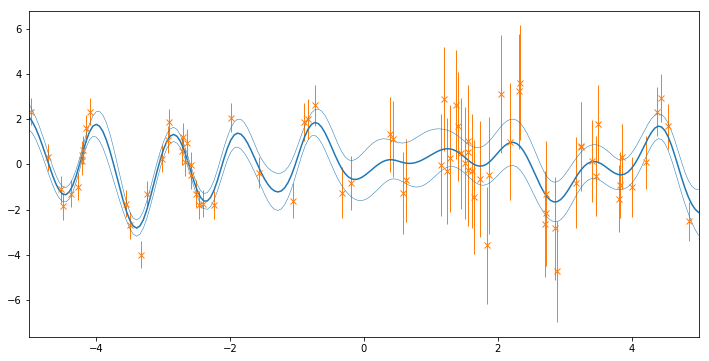

In [28]:
# let's do some plotting!
xx = np.linspace(-5, 5, 200)[:, None]

mu, var = model.predict_f(xx)

plt.figure(figsize=(12, 6))
plt.plot(xx, mu, 'C0')
plt.plot(xx, mu + 2*np.sqrt(var), 'C0', lw=0.5)
plt.plot(xx, mu - 2*np.sqrt(var), 'C0', lw=0.5)

plt.errorbar(X, Y, yerr=2*(np.sqrt(Sigma)), marker='x', lw=0, elinewidth=1., color='C1')
plt.xlim(-5, 5)

### Questions for the reader
1) What is the difference in meaning between the orange vertical bars and the blue regions in the prediction?

2) Why did we not implement conditional_mean and conditional_var in the HetGaussian likelihood? What could be done here?

2) What are some better kernel settings for this dataset? How could they be estimated?

# Demo 2: grouped noise variances

In this demo, we'll not assume that the noise variances are known, but we will assume that they're known in two groups. This represents an example where we might know that an instrument has varying fidelity for different regions, but not know what those fidelities are. 

Of course it would be straight forward to add more groups, or even one group per data point. We'll stick with two for simplicity. 

### Generate data

In [29]:
def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x 1
    F = 2.5 * np.sin(6 * X) + np.cos(3 * X)  # Mean function values
    groups = np.where(X>0, 0, 1)  
    Sigma = np.array([0.02, 0.5])[groups]
    Y = F + np.random.randn(N, 1) * np.sqrt(Sigma)  # noise data
    return X, Y, groups

X, Y, groups = generate_data()

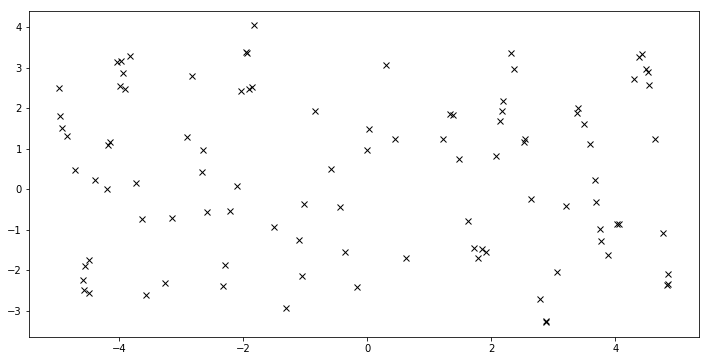

In [30]:
# here's a plot of the raw data.
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
_ = ax.plot(X, Y, 'kx')

### Data structure

In this case, we need to let the model know which group each data point belongs to. We'll use a similiar trick to the above, stacking the group identifier with the data.

In [31]:
Y_data = np.hstack([Y, groups])

### Build a likelihood

This time, we'll use a buoilt-in likelihood, SwitchedLikelihood, which is a container for other likelihoods, and applied them to the first Y_data column depending on the index in the second. We're able to access and optimize the parameters of those likelihoods. Here we'll (incorrectly) initialize the variances of our likelihoods to 1, to demostrate how we can recover reasonable values for these through maximum-likelihood estimation. 

In [32]:
likelihood = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.Gaussian(variance=1.0),
                                                    gpflow.likelihoods.Gaussian(variance=1.0)])

In [33]:
# model construction (notice that num_latent is 1)
kern = gpflow.kernels.Matern52(1, lengthscales=0.5)
model = gpflow.models.VGP(X, Y_data, kern=kern, likelihood=likelihood, num_latent=1)

In [34]:
# build the natural gradients optimizer
natgrad_optimizer = gpflow.training.NatGradOptimizer(gamma=1.)
natgrad_tensor = natgrad_optimizer.make_optimize_tensor(model, var_list=[(model.q_mu, model.q_sqrt)])

# A single natural gradient step solves the problem:
session = gpflow.get_default_session()
session.run(natgrad_tensor)

# update the cache of the variational parameters in the current session
model.anchor(session)

We've now fitted the VGP model to the data, but without optimizing over the hyper parameters. Plotting the data, we see that the fit is not terrible, but hasn't made use of our knowledge of the varying noise. 

(-5, 5)

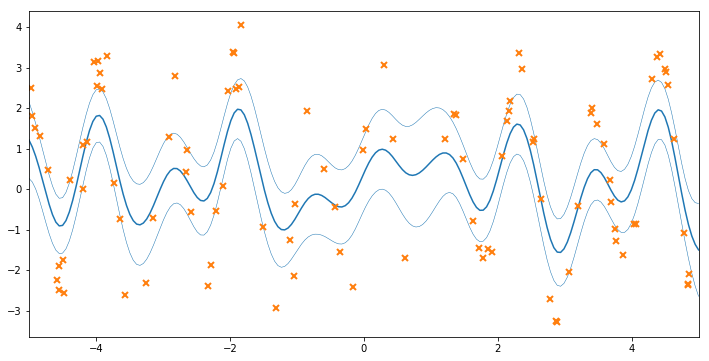

In [35]:
# let's do some plotting!
xx = np.linspace(-5, 5, 200)[:, None]

mu, var = model.predict_f(xx)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(xx, mu, 'C0')
ax.plot(xx, mu + 2*np.sqrt(var), 'C0', lw=0.5)
ax.plot(xx, mu - 2*np.sqrt(var), 'C0', lw=0.5)

ax.plot(X, Y, 'C1x', mew=2)
ax.set_xlim(-5, 5)

### Optimising the noise variances
Here we'll optimize over both the noise variance and the variational parameters, applying natural gradients inteleaved with the Adam optimizer. See the natural gradients notebook for more details and explanation. 

In [36]:
# Stop Adam from optimizing the variational parameters
model.q_mu.trainable = False
model.q_sqrt.trainable = False

# Create Adam tensor
adam_tensor = gpflow.train.AdamOptimizer(learning_rate=0.1).make_optimize_tensor(model)

In [37]:
for i in range(200):
    session.run(natgrad_tensor)
    session.run(adam_tensor)

# update the cache of the  parameters in the current session
model.anchor(session)

### Plotting the fitted model

Now that the noise variances have been estimated, we can see the final model fit. The predictive variance is higher on the left side of the plot, where we know that the data have different variance. We'll plot the known underlying function in green to see how effectively we've recovered the ground truth. We can also print the model to examine the estimated noise variances 

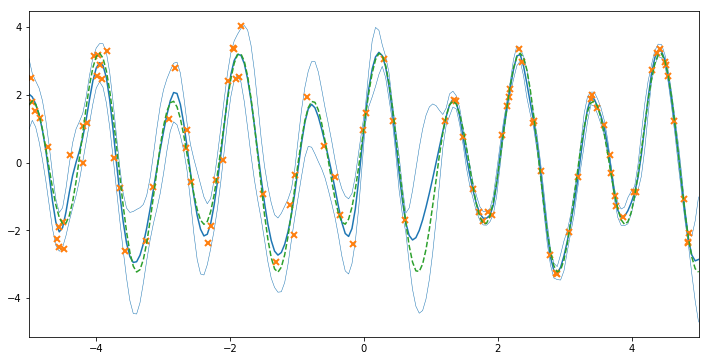

In [38]:
# let's do some plotting!
xx = np.linspace(-5, 5, 200)[:, None]

mu, var = model.predict_f(xx)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(xx, mu, 'C0')
ax.plot(xx, mu + 2*np.sqrt(var), 'C0', lw=0.5)
ax.plot(xx, mu - 2*np.sqrt(var), 'C0', lw=0.5)

ax.plot(X, Y, 'C1x', mew=2)
ax.set_xlim(-5, 5)
ax.plot(xx, 2.5 * np.sin(6 * xx) + np.cos(3 * xx), 'C2--')

In [39]:
model

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/lengthscales,Parameter,None,+ve,True,(),True,0.3130740167165497
VGP/kern/variance,Parameter,None,+ve,True,(),True,5.0938838644308815
VGP/likelihood/likelihood_list/0/variance,Parameter,None,+ve,True,(),True,0.016595980618290516
VGP/likelihood/likelihood_list/1/variance,Parameter,None,+ve,True,(),True,0.38072118568908664
VGP/q_mu,Parameter,None,(none),False,"(100, 1)",True,"[[-0.19428768432530447], [1.5502967782371415],..."
VGP/q_sqrt,Parameter,None,LoTri->vec,False,"(1, 100, 100)",True,"[[[0.483901641619183, 0.0, 0.0, 0.0, 0.0, 0.0,..."
